In [42]:
import string
from collections import defaultdict
from copy import deepcopy
from typing import Optional

import nltk
import pandas as pd
import preprocessor
import pyro.distributions as dist
import pyro.distributions.constraints
import torch
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from pyro.distributions import constraints
from pyroapi import pyro
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/lukas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/lukas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Load/Gen Data

In [3]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [43]:
def remove_generator(*stoplists):
    def remover(tokens):
        return [token for token in tokens if not any(token in stoplist for stoplist in stoplists)]

    return remover


def lemmatize_generator(lemmatizer):
    def lemmatize(tokens):
        return [lemmatizer.lemmatize(token) for token in tokens]

    return lemmatize


def stem_generator(stemmer):
    def stem(tokens):
        return [stemmer.stem(token) for token in tokens]

    return stem


def split_generator(on):
    def splitter(tokens):
        new_tokens = []
        for token in tokens:
            new_tokens.extend(token.split(on))
        return new_tokens

    return splitter

In [46]:
def preprocess_pipeline(sentence):
    tokens = word_tokenize(preprocessor.clean(sentence))
    ts = []
    for token in tokens:
        ts.extend(token.split('-'))
    tokens = deepcopy(ts)
    ts = []
    for token in tokens:
        ts.extend(token.split('/'))
    tokens = ts
    return [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens if not any(token in stoplist for stoplist in
                                                                                     [list(string.punctuation),
                                                                                      list(string.digits),
                                                                                      ["url", "amp", "should'vetaken",
                                                                                       '', u'', "''", "..", "...",
                                                                                       "....",
                                                                                       ".....",
                                                                                       "......", ",,", "'s", "`s",
                                                                                       "'nt", "n't",
                                                                                       "'m", "'re", "\\5", "``", ' ']])]




In [6]:
data = pd.read_csv("/home/lukas/Dev/Uni/WS21/NLP/project-nlp-ninjas/datasets/OLID/olid-training-v1.0.tsv",
                   sep='\t').drop(columns=["id", "subtask_b", "subtask_c"]).rename(
    columns={"subtask_a": "label", "tweet": "sentence"}).replace('OFF', 1.0).replace('NOT', 0.0)
data["sentence"] = data["sentence"].apply(preprocess_pipeline)
data

,sentence,label
0,"[she, should, ask, a, few, nativ, american, wh...",1.0
1,"[go, home, your, drunk]",1.0
2,"[amazon, is, investig, chines, employe, who, a...",0.0
3,"[someon, thi, piec, of, shit, to, a, volcano.]",1.0
4,"[obama, want, liber, illeg, to, move, into, re...",0.0
...,...,...
13235,"[sometim, i, get, strong, vibe, from, peopl, a...",1.0
13236,"[benidorm, creamfield, maga, not, too, shabbi,...",0.0
13237,"[and, whi, report, thi, garbag, we, do, give, ...",1.0
13238,[pussi],1.0


In [7]:
data_X, data_y = data["sentence"], data["label"]

# Split Data

In [8]:
X_learn, X_evaluate, y_learn, y_evaluate = train_test_split(data_X, data_y, test_size=0.1, random_state=0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=0.2, random_state=0)
data_X.shape, X_train.shape, X_test.shape, X_evaluate.shape

((13240,), (9532,), (2384,), (1324,))

# Build lexicon

In [10]:
def build_lexicon(X, y):
    lexicon = defaultdict(lambda: {0: 0, 1: 0})
    for i in X.index.values:
        sentence = X[i]
        label = y[i]
        for word in sentence:
            lexicon[word][label] += 1
    return lexicon

In [11]:
global_lexicon = build_lexicon(X_train, y_train)
global_lexicon, len(global_lexicon)

(defaultdict(<function __main__.build_lexicon.<locals>.<lambda>()>,
             {'great': {0: 121, 1: 51},
              'here': {0: 140, 1: 40},
              'how': {0: 344, 1: 200},
              'today': {0: 68, 1: 20},
              'ha': {0: 337, 1: 209},
              'gone': {0: 24, 1: 12},
              'flori': {0: 0, 1: 1},
              'want': {0: 262, 1: 146},
              'to': {0: 2952, 1: 1613},
              'spank': {0: 1, 1: 2},
              'me': {0: 309, 1: 172},
              'leah': {0: 0, 1: 1},
              'stab': {0: 1, 1: 2},
              'curti': {0: 0, 1: 1},
              'wont': {0: 24, 1: 17},
              'back': {0: 169, 1: 69},
              'up': {0: 316, 1: 216},
              'adam': {0: 3, 1: 1},
              'still': {0: 132, 1: 68},
              'look': {0: 222, 1: 113},
              'at': {0: 335, 1: 199},
              'or': {0: 329, 1: 213},
              'howev': {0: 17, 1: 3},
              'old': {0: 71, 1: 50},
              'a

# Build params

In [90]:
def model(alpha, beta):
    latent_prediction = pyro.sample("latent_prediction", dist.Beta(torch.tensor(1.), torch.tensor(1.)))
    obs = torch.concat((torch.zeros(alpha), torch.ones(beta)))
    with pyro.plate("N", alpha + beta):
        return pyro.sample("obs", dist.Bernoulli(latent_prediction), obs=obs)

In [91]:
def guide(alpha, beta):
    alpha_posterior = pyro.param("alpha_posterior", torch.tensor(1.), constraint=constraints.positive)
    beta_posterior = pyro.param("beta_posterior", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("latent_prediction", dist.Beta(alpha_posterior,
                                                      beta_posterior))


In [92]:
def bayesian_update(alpha,
                    beta,
                    max_opt_steps=100,
                    loss_threshold=None,
                    clear_param_store=True,
                    cuda=False,
                    pbar: Optional[tqdm] = None):
    if clear_param_store:
        pyro.clear_param_store()
    if cuda is not None:
        if cuda and torch.cuda.is_available():
            torch.device("cuda")
        elif not cuda:
            torch.device("cpu")
    adam = pyro.optim.Adam({"lr": 0.025})
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, adam, elbo)
    steps = 0
    loss = (loss_threshold or 0) + 1

    while steps < max_opt_steps and loss > (loss_threshold or loss - 1):
        loss = svi.step(alpha, beta)
        steps += 1
        if pbar is not None:
            pbar.update()
    pbar.update(max_opt_steps - steps)
    return pyro.param("alpha_posterior"), pyro.param("beta_posterior")

In [15]:
for word in global_lexicon:
    global_lexicon[word]['alpha'] = global_lexicon[word][0] + 1
    global_lexicon[word]['beta'] = global_lexicon[word][1] + 1

global_lexicon = defaultdict(lambda: {
    0: 0,
    1: 0,
    'alpha': 1,
    'beta': 1}, global_lexicon)
global_lexicon

defaultdict(<function __main__.<lambda>()>,
            {'great': {0: 121, 1: 51, 'alpha': 122, 'beta': 52},
             'here': {0: 140, 1: 40, 'alpha': 141, 'beta': 41},
             'how': {0: 344, 1: 200, 'alpha': 345, 'beta': 201},
             'today': {0: 68, 1: 20, 'alpha': 69, 'beta': 21},
             'ha': {0: 337, 1: 209, 'alpha': 338, 'beta': 210},
             'gone': {0: 24, 1: 12, 'alpha': 25, 'beta': 13},
             'flori': {0: 0, 1: 1, 'alpha': 1, 'beta': 2},
             'want': {0: 262, 1: 146, 'alpha': 263, 'beta': 147},
             'to': {0: 2952, 1: 1613, 'alpha': 2953, 'beta': 1614},
             'spank': {0: 1, 1: 2, 'alpha': 2, 'beta': 3},
             'me': {0: 309, 1: 172, 'alpha': 310, 'beta': 173},
             'leah': {0: 0, 1: 1, 'alpha': 1, 'beta': 2},
             'stab': {0: 1, 1: 2, 'alpha': 2, 'beta': 3},
             'curti': {0: 0, 1: 1, 'alpha': 1, 'beta': 2},
             'wont': {0: 24, 1: 17, 'alpha': 25, 'beta': 18},
             'back':

In [55]:
def optimize(lexicon, opt_steps):

    with tqdm(total=len(global_lexicon) * opt_steps, mininterval=1, miniters=144) as pbar:
        for word in lexicon:
            alpha_posterior, beta_posterior = bayesian_update(lexicon[word]['alpha'],
                                                          lexicon[word]['beta'],
                                                          max_opt_steps=opt_steps,
                                                          loss_threshold=1e-5,
                                                          cuda=True,
                                                          pbar=pbar)
        lexicon[word]['alpha_posterior'] = alpha_posterior
        lexicon[word]['beta_posterior'] = beta_posterior

    lexicon = defaultdict(lambda: {
    0: 0,
    1: 0,
    'alpha': 1,
    'beta': 1,
    'alpha_posterior': torch.tensor(1.0),
    'beta_posterior': torch.tensor(1.0),
    }, lexicon)
    return lexicon

In [ ]:
optimize(global_lexicon, 500)

# Classify

In [50]:
def classify(sentence, lexicon):
    expectations = []
    for word in preprocess_pipeline(sentence):
        alpha = lexicon[word]['alpha_posterior']
        beta = lexicon[word]['beta_posterior']
        distribution = dist.Beta(alpha, beta)
        expectations.append(distribution.mean)

    expectations_t = torch.tensor(expectations)
    return torch.std_mean(expectations_t)

In [51]:
global_lexicon["fuck"], global_lexicon["thi"], global_lexicon["shit"]

({0: 24,
  1: 257,
  'alpha': 25,
  'beta': 258,
  'alpha_posterior': tensor(0.4584, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(5.3092, grad_fn=<AddBackward0>)},
 {0: 788,
  1: 546,
  'alpha': 789,
  'beta': 547,
  'alpha_posterior': tensor(8.3538, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(4.1543, grad_fn=<AddBackward0>)},
 {0: 30,
  1: 249,
  'alpha': 31,
  'beta': 250,
  'alpha_posterior': tensor(1.2511, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(6.7619, grad_fn=<AddBackward0>)})

In [52]:
global_lexicon["i"], global_lexicon["love"], global_lexicon["you"]

({0: 1688,
  1: 836,
  'alpha': 1689,
  'beta': 837,
  'alpha_posterior': tensor(7.2603, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(6.3545, grad_fn=<AddBackward0>)},
 {0: 239,
  1: 67,
  'alpha': 240,
  'beta': 68,
  'alpha_posterior': tensor(11.0789, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(1.6848, grad_fn=<AddBackward0>)},
 {0: 2616,
  1: 1300,
  'alpha': 2617,
  'beta': 1301,
  'alpha_posterior': tensor(9.1507, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(5.6108, grad_fn=<AddBackward0>)})

In [53]:
global_lexicon["pesky"], global_lexicon["liber"]

({0: 0,
  1: 0,
  'alpha': 1,
  'beta': 1,
  'alpha_posterior': tensor(1.),
  'beta_posterior': tensor(1.)},
 {0: 704,
  1: 461,
  'alpha': 705,
  'beta': 462,
  'alpha_posterior': tensor(8.1613, grad_fn=<AddBackward0>),
  'beta_posterior': tensor(4.5569, grad_fn=<AddBackward0>)})

In [54]:
classify("Fuck this shit", global_lexicon), classify("I love you", global_lexicon), classify("Pesky liberals",
                                                                                             global_lexicon)

((tensor(0.3199), tensor(0.3012)),
 (tensor(0.1737), tensor(0.6737)),
 (tensor(0.2366), tensor(0.8090)))

In [93]:
def bayesian_update(alpha,
                    beta,
                    max_opt_steps=100,
                    loss_threshold=None,
                    clear_param_store=True,
                    cuda=False,
                    pbar: Optional[tqdm] = None):
    if clear_param_store:
        pyro.clear_param_store()
    if cuda is not None:
        if cuda and torch.cuda.is_available():
            torch.device("cuda")
        elif not cuda:
            torch.device("cpu")
    adam = pyro.optim.Adam({"lr": 0.025})
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, adam, elbo)
    steps = 0
    loss = (loss_threshold or 0) + 1
    losses = []
    params = []
    while steps < max_opt_steps and loss > (loss_threshold or loss - 1):
        loss = svi.step(alpha, beta)
        steps += 1
        losses.append({"loss": loss})
        params.append({"alpha": pyro.param("alpha_posterior").item(), "beta": pyro.param("beta_posterior").item()})
        if pbar is not None:
            pbar.update()
    pbar.update(max_opt_steps - steps)
    return pyro.param("alpha_posterior"), pyro.param("beta_posterior"), losses, params

In [94]:
alpha = 1
beta = 10
print(alpha, beta)
alpha_p, beta_p, losses, params = bayesian_update(alpha, beta, 10_000, pbar=tqdm(total=10_000))

1 10


  0%|          | 0/10000 [00:00<?, ?it/s]

<AxesSubplot:>

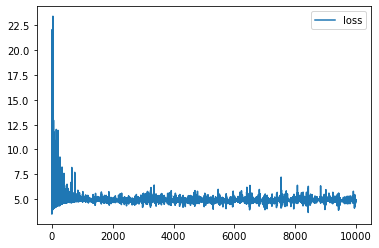

In [95]:
df = pd.DataFrame(losses)

df.plot()

<AxesSubplot:>

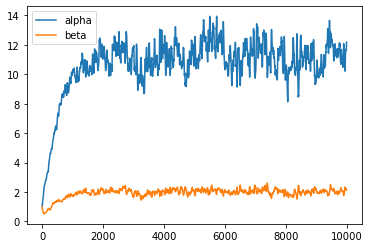

In [96]:
df = pd.DataFrame(params)

df.plot()

In [97]:
from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np

In [98]:
def show_dist(a, b):
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)

    return ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

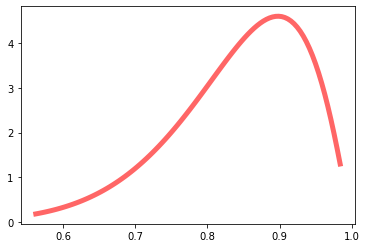

In [99]:
show_dist(params[-10]["alpha"],params[-10]["beta"])

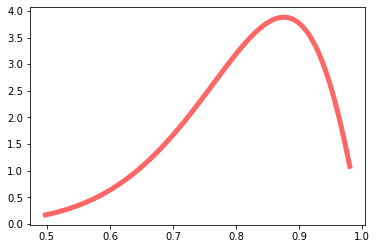

In [100]:
show_dist(params[-1000]["alpha"],params[-1000]["beta"])

In [89]:
# Evaluate